In [4]:
import numpy as np 
import pandas as pd
import os
import sys
import scipy as sp
import math
import matplotlib.pyplot as plt 
import csv
from itertools import cycle
import tensorflow as tf
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter
from scipy import stats
from scipy.optimize import curve_fit



In [13]:
'''1320 @ 200	(number of samples, data rate)
914.73	(body and load weights)
'''
# Reading a specific sheet
df = pd.read_excel("/Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/LA Tech/2023/Hitting/Alonso, Nick-Force Only-2023.09.09 08.53.29.255.xlsx", sheet_name="Sheet1") # mac pathname
#df = pd.read_excel(r"C:\Users\User\OneDrive\Desktop\Hitting\Alonso, Nick-Force Only-2023.09.09 08.53.29.255.xlsx")#windows pathname

# Showing the DataFrame
print(df)
t = df['Time_s_']
FxR = df['RawFx_R_N_']
FyR = df['RawFy_R_N_']
FzR = df['RawFz_R_N_']
MxR = df['RawMx_R_Nm_']
MyR = df['RawMy_R_Nm_']
MzR = df['RawMz_R_Nm_']
FxL = df['RawFx_L_N_']
FyL = df['RawFy_L_N_']
FzL = df['RawFz_L_N_']
MxL = df['RawMx_L_Nm_']
MyL = df['RawMy_L_Nm_']
MzL = df['RawMz_L_Nm_']
COP_xR = df['COPX_R']
COP_yR = df['COPY_R']
COP_xL = df['COPX_L']
COP_yL = df['COPY_L']






     Time_s_  RawFx_R_N_  RawFy_R_N_  RawFz_R_N_  RawMx_R_Nm_  RawMy_R_Nm_  \
0        NaN         NaN         NaN         NaN          NaN          NaN   
1        NaN         NaN         NaN         NaN          NaN          NaN   
2        NaN         NaN         NaN         NaN          NaN          NaN   
3        NaN         NaN         NaN         NaN          NaN          NaN   
4    738.690         NaN         NaN         NaN          NaN          NaN   
..       ...         ...         ...         ...          ...          ...   
983    4.870  186.125798   -5.024979  740.238898   -68.350271    53.718072   
984    4.875  180.464030   -5.489700  740.238898   -68.350271    53.718072   
985    4.880  179.028943   -2.536410  740.238898   -68.350271    53.718072   
986    4.885  181.705329    1.404950  740.238898   -68.350271    53.718072   
987    4.890  174.802628    5.690670  740.238898   -68.350271    53.718072   

     RawMz_R_Nm_  RawFx_L_N_  RawFy_L_N_  RawFz_L_N_  RawMx_L_N

In [14]:
# Function to apply Gaussian smoothing
def apply_gaussian_smoothing(data, sigma):
    return gaussian_filter(data, sigma)

# Function to find and plot significant peaks
def find_and_plot_extrema(data, time, label, peak_marker='x', trough_marker='o', 
                          height_threshold=100, min_distance_in_seconds=0.3, sample_rate=200):
    min_distance_in_samples = int(min_distance_in_seconds * sample_rate)
    
    # Find and plot Peaks
    peaks, _ = find_peaks(data, height=height_threshold, distance=min_distance_in_samples)
    plot_and_annotate(data, time[:-1], peaks, label, peak_marker, "Peaks")
    
    # Find and plot Troughs
    troughs, _ = find_peaks(-data, height=height_threshold, distance=min_distance_in_samples)
    plot_and_annotate(data, time[:-1], troughs, label, trough_marker, "Troughs")

# Helper function to handle the plotting and annotating
def plot_and_annotate(data, time, extrema_indices, label, marker, extrema_type):
    if len(extrema_indices) > 0:
        plt.plot(time[extrema_indices], data[extrema_indices], marker, label=f'{label} {extrema_type}')
        
        # Initialize previous annotation values to None
        prev_t, prev_value = None, None

        print(f"\nSignificant {extrema_type.lower()} for {label}:")
        for i in extrema_indices:
            t, value = time[i], data[i]
            offset_x, offset_y = 0, 10  # default offsets
            
            # If a previous annotation exists, check for overlap and adjust offsets
            if prev_t is not None:
                if abs(t - prev_t) < 0.2:  # If the time values are close (tweak as needed)
                    offset_x = 15
                if abs(value - prev_value) < 50:  # If the force values are close (tweak as needed)
                    offset_y = 20
            
            plt.annotate(f'({t:.2f}, {value:.2f})', 
                         (t, value), 
                         textcoords="offset points", 
                         xytext=(offset_x, offset_y), 
                         ha='center')
            
            print(f't = {t:.2f}, Value = {value:.2f}')
            prev_t, prev_value = t, value  # Update previous annotation values
    else:
        print(f'No significant {extrema_type.lower()} found for {label}.')


# Function to find the rate of force production
def rate_of_force_production(force_data, time_data):
    delta_t = time_data[1] - time_data[0]
    rate = np.diff(force_data) / delta_t
    return rate


Peak data for Stride and Trail Legs
Peak rate of force production for Stride and Trail Legs

Significant peaks for Stride:
t = 3.29, Value = 1057.10
No significant troughs found for Stride.

Significant peaks for Trail:
t = 3.00, Value = 807.08
t = 4.83, Value = 759.47
No significant troughs found for Trail.
No significant peaks found for Stride.
No significant troughs found for Stride.
No significant peaks found for Trail.
No significant troughs found for Trail.
No significant peaks found for Stride.
No significant troughs found for Stride.
No significant peaks found for Trail.
No significant troughs found for Trail.


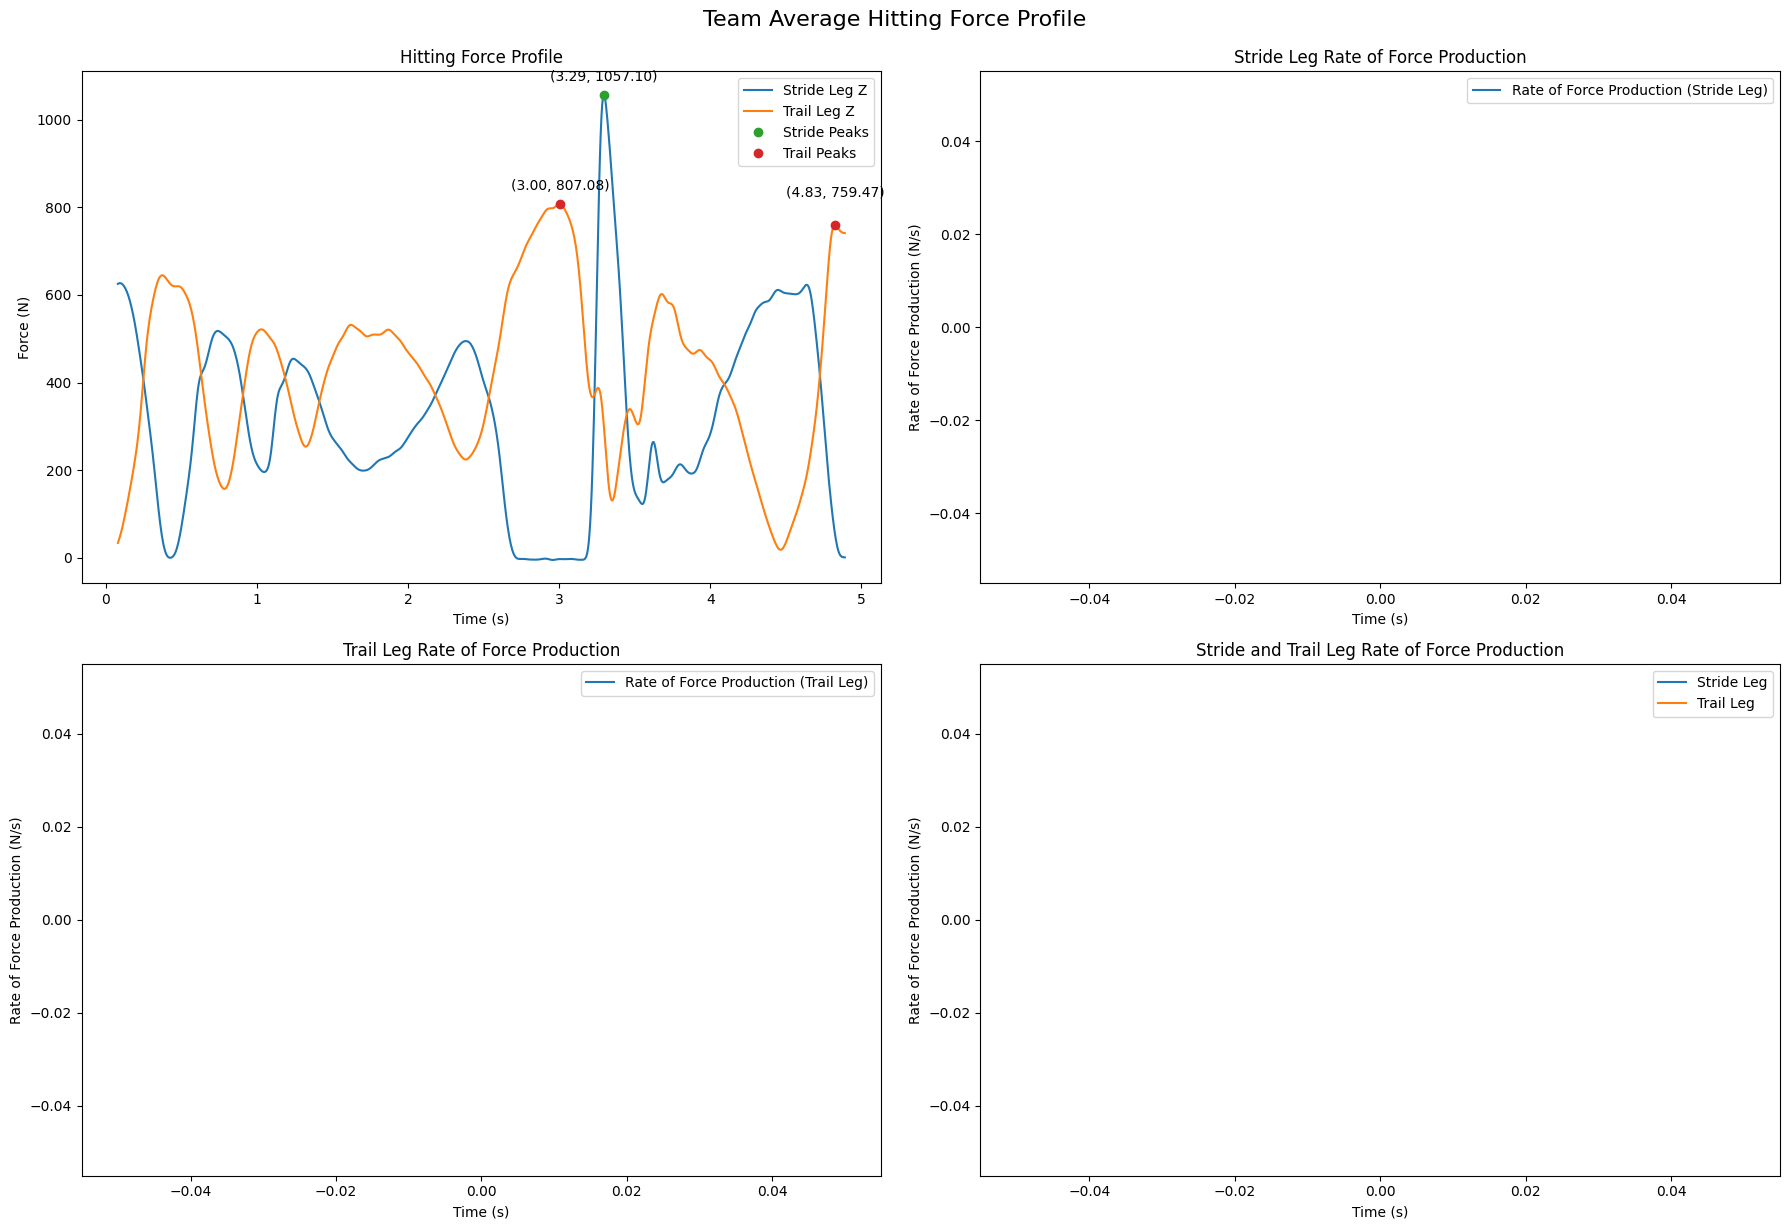

In [17]:
# Set filter requirements
sigma = 4
sample_rate = 200  # Assuming FzL and FzR are sampled at 200 Hz
cutoff_frequency = 50  # Cut-off frequency of the filter in Hz

# Assuming FzL and FzR are your data arrays and t is your time array
# FzL, FzR, t = ...

# Apply Gaussian filter
stride_data_smoothed = apply_gaussian_smoothing(FzL, sigma)
trail_data_smoothed = apply_gaussian_smoothing(FzR, sigma)

# Calculate rate of force production
rate_stride =  apply_gaussian_smoothing(rate_of_force_production(stride_data_smoothed, t),sigma)
rate_trail =  apply_gaussian_smoothing(rate_of_force_production(trail_data_smoothed, t),sigma)


# Plotting
print("Peak data for Stride and Trail Legs")
print("Peak rate of force production for Stride and Trail Legs")
# Combined plotting
plt.figure(figsize=(18, 12))

# First subplot for Stride and Trail Leg Z Data
plt.subplot(2, 2, 1)
plt.plot(t, stride_data_smoothed, label='Stride Leg Z')
plt.plot(t, trail_data_smoothed, label='Trail Leg Z')

find_and_plot_extrema(stride_data_smoothed, t, 'Stride', peak_marker='o', trough_marker='x', height_threshold=650)  
find_and_plot_extrema(trail_data_smoothed, t, 'Trail', peak_marker='o', trough_marker='x', height_threshold=650)   
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.title('Hitting Force Profile')
plt.legend()

# Second subplot for Rate of Force Production (Stride Leg)
plt.subplot(2, 2, 2)
plt.plot(t[:-1], rate_stride, label='Rate of Force Production (Stride Leg)')
find_and_plot_extrema(rate_stride, t[:-1], 'Stride', peak_marker='o', trough_marker='x', height_threshold=1000)  
plt.xlabel('Time (s)')
plt.ylabel('Rate of Force Production (N/s)')
plt.title('Stride Leg Rate of Force Production')
plt.legend()

# Third subplot for Rate of Force Production (Trail Leg)
plt.subplot(2, 2, 3)
plt.plot(t[:-1], rate_trail, label='Rate of Force Production (Trail Leg)')
find_and_plot_extrema(rate_trail, t[:-1], 'Trail', peak_marker='o', trough_marker='x', height_threshold=1000)  
plt.xlabel('Time (s)')
plt.ylabel('Rate of Force Production (N/s)')
plt.title('Trail Leg Rate of Force Production')
plt.legend()

# Fourth subplot for combined plot of Stride and Trail Leg with different threshold
plt.subplot(2, 2, 4)
plt.plot(t[:-1], rate_stride, label='Stride Leg')
find_and_plot_extrema(rate_stride, t[:-1], 'Stride', peak_marker='o', trough_marker='x', height_threshold=3000)  
plt.plot(t[:-1], rate_trail, label='Trail Leg')
find_and_plot_extrema(rate_trail, t[:-1], 'Trail', peak_marker='o', trough_marker='x', height_threshold=3000)  
plt.xlabel('Time (s)')
plt.ylabel('Rate of Force Production (N/s)')
plt.title('Stride and Trail Leg Rate of Force Production')
plt.legend()

plt.tight_layout()
plt.suptitle('Team Average Hitting Force Profile', fontsize=16, y=1.02)
plt.show()




In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import gaussian_filter

# 1. Read and Aggregate All Player Data
data_dir = '/Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/LA Tech/2023/Force_plate_Testing/BASEBALL /Hitting_BASEBALL/Right_handed'
all_files = [f for f in os.listdir(data_dir) if f.endswith('.xlsx')]
players_data = {}

for file in all_files:
    player_name = os.path.splitext(file)[0]
    df = pd.read_excel(os.path.join(data_dir, file))
    players_data[player_name] = df

# 2. Data Synchronization
common_time = np.linspace(0, max([df['Time_s'].max() for df in players_data.values()]), num=5000)  # Example num of points
interpolated_data = {}

for player, df in players_data.items():
    interpolated_force = np.interp(common_time, df['Time_s'], df['RawFv_R.L'])  # Interpolate for one force column as an example
    interpolated_data[player] = interpolated_force

# 3. Individual Player Plots
for player, force in interpolated_data.items():
    plt.figure(figsize=(12, 8))
    
    # Raw Force vs Time
    plt.subplot(2, 2, 1)
    plt.plot(common_time, force)
    plt.title(f"{player} - Raw Force vs Time")
    
    # Smoothed Force vs Time
    plt.subplot(2, 2, 2)
    smoothed_force = gaussian_filter(force, sigma=5)  # Adjust sigma as needed
    plt.plot(common_time, smoothed_force)
    plt.title(f"{player} - Smoothed Force vs Time")
    
    # Rest can be added similar to your previous code for peaks, troughs, and rate of force production
    
    plt.tight_layout()
    plt.savefig(f"{player}_plots.png")

# 4. Compute the Mean/Median Plot
mean_forces = np.mean(list(interpolated_data.values()), axis=0)
# Alternatively for median: median_forces = np.median(list(interpolated_data.values()), axis=0)

plt.figure(figsize=(12, 6))
for force in interpolated_data.values():
    plt.plot(common_time, force, alpha=0.3)  # Translucent individual player plots
plt.plot(common_time, mean_forces, color='black', linewidth=2.5)  # Mean force plot
plt.title("Mean Force vs Time")
plt.savefig("mean_force_plot.png")

# 5. Output & Visualization (if running in a notebook)
plt.show()


ImportError: cannot import name 'gaussian_filter' from 'scipy.signal' (/Users/charlesarnold/anaconda3/lib/python3.10/site-packages/scipy/signal/__init__.py)